In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

In [2]:
power_data = pd.read_csv("C:/Users/yujin/Downloads/MONASH/Y3 S3/FIT 3164/fyp/Power_Generation_Data.csv")
weather_data = pd.read_csv("C:/Users/yujin/Downloads/MONASH/Y3 S3/FIT 3164/fyp/Weather_Sensor_Data.csv")

In [3]:
print(power_data.head())

        DATE_TIME  DC_POWER  AC_POWER
0  15/5/2020 0:00       0.0       0.0
1  15/5/2020 0:00       0.0       0.0
2  15/5/2020 0:00       0.0       0.0
3  15/5/2020 0:00       0.0       0.0
4  15/5/2020 0:00       0.0       0.0


In [4]:
print(weather_data.head())

        DATE_TIME  MODULE_TEMPERATURE  IRRADIATION
0  15/5/2020 0:00           22.857507          0.0
1  15/5/2020 0:15           22.761668          0.0
2  15/5/2020 0:30           22.592306          0.0
3  15/5/2020 0:45           22.360852          0.0
4  15/5/2020 1:00           22.165423          0.0


In [5]:
# Convert DATE_TIME columns to datetime objects
weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'], format='%d/%m/%Y %H:%M')
power_data['DATE_TIME'] = pd.to_datetime(power_data['DATE_TIME'], format='%d/%m/%Y %H:%M')

# Group the Power Generation Data by DATE_TIME and calculate mean for DC_POWER and AC_POWER
grouped_power_data = power_data.groupby('DATE_TIME', as_index=False)[['DC_POWER', 'AC_POWER']].mean()

In [6]:
print(grouped_power_data.head())

            DATE_TIME  DC_POWER  AC_POWER
0 2020-05-15 00:00:00       0.0       0.0
1 2020-05-15 00:15:00       0.0       0.0
2 2020-05-15 00:30:00       0.0       0.0
3 2020-05-15 00:45:00       0.0       0.0
4 2020-05-15 01:00:00       0.0       0.0


In [7]:
# Merge the grouped Power Generation Data with Weather Sensor Data
merged_data_grouped = pd.merge(grouped_power_data, weather_data, on='DATE_TIME', how='inner')
print(merged_data_grouped.head())

            DATE_TIME  DC_POWER  AC_POWER  MODULE_TEMPERATURE  IRRADIATION
0 2020-05-15 00:00:00       0.0       0.0           22.857507          0.0
1 2020-05-15 00:15:00       0.0       0.0           22.761668          0.0
2 2020-05-15 00:30:00       0.0       0.0           22.592306          0.0
3 2020-05-15 00:45:00       0.0       0.0           22.360852          0.0
4 2020-05-15 01:00:00       0.0       0.0           22.165423          0.0


In [8]:
# Extract time-based features
merged_data_grouped['HOUR'] = merged_data_grouped['DATE_TIME'].dt.hour
merged_data_grouped['DAY_OF_WEEK'] = merged_data_grouped['DATE_TIME'].dt.dayofweek
merged_data_grouped['MONTH'] = merged_data_grouped['DATE_TIME'].dt.month

# Calculate rolling means and sums
window_size = 4  # Example window size
merged_data_grouped['ROLLING_DC_POWER_MEAN'] = merged_data_grouped['DC_POWER'].rolling(window=window_size, min_periods=1).mean()
merged_data_grouped['ROLLING_AC_POWER_MEAN'] = merged_data_grouped['AC_POWER'].rolling(window=window_size, min_periods=1).mean()
merged_data_grouped['ROLLING_MODULE_TEMP_MEAN'] = merged_data_grouped['MODULE_TEMPERATURE'].rolling(window=window_size, min_periods=1).mean()
merged_data_grouped['ROLLING_IRRADIATION_MEAN'] = merged_data_grouped['IRRADIATION'].rolling(window=window_size, min_periods=1).mean()

# Display the first few rows of the final dataset
print(merged_data_grouped.head())

            DATE_TIME  DC_POWER  AC_POWER  MODULE_TEMPERATURE  IRRADIATION  \
0 2020-05-15 00:00:00       0.0       0.0           22.857507          0.0   
1 2020-05-15 00:15:00       0.0       0.0           22.761668          0.0   
2 2020-05-15 00:30:00       0.0       0.0           22.592306          0.0   
3 2020-05-15 00:45:00       0.0       0.0           22.360852          0.0   
4 2020-05-15 01:00:00       0.0       0.0           22.165423          0.0   

   HOUR  DAY_OF_WEEK  MONTH  ROLLING_DC_POWER_MEAN  ROLLING_AC_POWER_MEAN  \
0     0            4      5                    0.0                    0.0   
1     0            4      5                    0.0                    0.0   
2     0            4      5                    0.0                    0.0   
3     0            4      5                    0.0                    0.0   
4     1            4      5                    0.0                    0.0   

   ROLLING_MODULE_TEMP_MEAN  ROLLING_IRRADIATION_MEAN  
0           

In [9]:
# Function to prepare data
def prepare_data(features, target_column):
    y = merged_data_grouped[target_column]
    X_train, X_test, y_train, y_test = train_test_split(merged_data_grouped[features], y, test_size=0.2, random_state=42)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Reshape the data to a 3D format required for LSTM
    X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
    
    return X_train_lstm, X_test_lstm, y_train, y_test

In [10]:
# Define the DC Power features
features_dc = ['MODULE_TEMPERATURE', 'IRRADIATION', 'HOUR', 'DAY_OF_WEEK', 'MONTH',
               'ROLLING_DC_POWER_MEAN', 'ROLLING_MODULE_TEMP_MEAN', 'ROLLING_IRRADIATION_MEAN']
target_dc = 'DC_POWER'

# Define the AC Power features
features_ac = ['MODULE_TEMPERATURE', 'IRRADIATION', 'HOUR', 'DAY_OF_WEEK', 'MONTH',
               'ROLLING_AC_POWER_MEAN', 'ROLLING_MODULE_TEMP_MEAN', 'ROLLING_IRRADIATION_MEAN']
target_ac = 'AC_POWER'

# Prepare the data for AC Power
X_train_ac, X_test_ac, y_train_ac, y_test_ac = prepare_data(features_ac, target_ac)

# Prepare the data for DC Power
X_train_dc, X_test_dc, y_train_dc, y_test_dc = prepare_data(features_dc, target_dc)

In [11]:
# Function to create the LSTM model with Input layer
def create_lstm_model(optimizer='adam', neurons=64):
    model = Sequential([
        Input(shape=(1, X_train_dc.shape[2])),  # Use the Input layer
        LSTM(neurons, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Function to perform direct hyperparameter tuning
def tune_hyperparameters(X_train, X_test, y_train, y_test, optimizer_list, neurons_list, epochs_list, batch_size_list):
    best_params = None
    best_rmse = float('inf')
    results = []
    
    for optimizer in optimizer_list:
        for neurons in neurons_list:
            for epochs in epochs_list:
                for batch_size in batch_size_list:
                    model = create_lstm_model(optimizer=optimizer, neurons=neurons)
                    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                    test_predictions = model.predict(X_test)
                    rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
                    
                    params = {
                        'optimizer': optimizer,
                        'neurons': neurons,
                        'epochs': epochs,
                        'batch_size': batch_size
                    }
                    results.append((params, rmse))
                    
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = params
                        
                    print(f"Params: {params}, RMSE: {rmse}")
                    
    return best_params, best_rmse, results

# Hyperparameter lists
optimizer_list = ['adam']
neurons_list = [32, 64, 128]
epochs_list = [50, 100]
batch_size_list = [32, 64]

In [12]:
# Perform hyperparameter tuning for AC Power Model
best_params_ac, best_rmse_ac, tuning_results_ac = tune_hyperparameters(X_train_ac, X_test_ac, y_train_ac, y_test_ac,optimizer_list, neurons_list, epochs_list, batch_size_list)

print("\nBest Parameters for AC Power Model:", best_params_ac)
print("Best RMSE for AC Power Model:", best_rmse_ac)
                                                                       
# Evaluate the final AC Power model with best parameters
best_ac_model = create_lstm_model(optimizer=best_params_ac['optimizer'], neurons=best_params_ac['neurons'])
best_ac_model.fit(X_train_ac, y_train_ac, epochs=best_params_ac['epochs'], batch_size=best_params_ac['batch_size'], verbose=1)
train_ac_predictions = best_ac_model.predict(X_train_ac)
test_ac_predictions = best_ac_model.predict(X_test_ac)

# RMSE on train and test
train_ac_rmse = np.sqrt(mean_squared_error(y_train_ac, train_ac_predictions))
test_ac_rmse = np.sqrt(mean_squared_error(y_test_ac, test_ac_predictions))

train_ac_r2 = r2_score(y_train_ac, train_ac_predictions)
test_ac_r2 = r2_score(y_test_ac, test_ac_predictions)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Params: {'optimizer': 'adam', 'neurons': 32, 'epochs': 50, 'batch_size': 32}, RMSE: 30.751283072320685
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Params: {'optimizer': 'adam', 'neurons': 32, 'epochs': 50, 'batch_size': 64}, RMSE: 45.047469315361695
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Params: {'optimizer': 'adam', 'neurons': 32, 'epochs': 100, 'batch_size': 32}, RMSE: 22.422170646991084
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Params: {'optimizer': 'adam', 'neurons': 32, 'epochs': 100, 'batch_size': 64}, RMSE: 25.592987013323604
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Params: {'optimizer': 'adam', 'neurons': 64, 'epochs': 50, 'batch_size': 32}, RMSE: 26.02596547410149
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: {'optimizer': 'adam', 'neurons': 64, 'epochs': 50, 'batch_size': 64}, RMSE: 31.863825264549856
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Params: {'optimizer': 'adam', 'neurons': 64, 'epochs': 100, 'batch_size': 32}, RMSE: 21.39947249333706


In [13]:
# Perform hyperparameter tuning for DC Power Model
best_params_dc, best_rmse_dc, tuning_results_dc = tune_hyperparameters(X_train_dc, X_test_dc, y_train_dc, y_test_dc,
                                                                       optimizer_list, neurons_list, epochs_list, batch_size_list)

print("\nBest Parameters for DC Power Model:", best_params_dc)
print("Best RMSE for DC Power Model:", best_rmse_dc)

# Evaluate the final DC Power model with best parameters
best_dc_model = create_lstm_model(optimizer=best_params_dc['optimizer'], neurons=best_params_dc['neurons'])
best_dc_model.fit(X_train_dc, y_train_dc, epochs=best_params_dc['epochs'], batch_size=best_params_dc['batch_size'], verbose=1)
train_dc_predictions = best_dc_model.predict(X_train_dc)
test_dc_predictions = best_dc_model.predict(X_test_dc)

train_dc_rmse = np.sqrt(mean_squared_error(y_train_dc, train_dc_predictions))
test_dc_rmse = np.sqrt(mean_squared_error(y_test_dc, test_dc_predictions))

train_dc_r2 = r2_score(y_train_dc, train_dc_predictions)
test_dc_r2 = r2_score(y_test_dc, test_dc_predictions)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Params: {'optimizer': 'adam', 'neurons': 32, 'epochs': 50, 'batch_size': 32}, RMSE: 414.91911954495
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Params: {'optimizer': 'adam', 'neurons': 32, 'epochs': 50, 'batch_size': 64}, RMSE: 857.6789515152113
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Params: {'optimizer': 'adam', 'neurons': 32, 'epochs': 100, 'batch_size': 32}, RMSE: 252.1647952261052
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Params: {'optimizer': 'adam', 'neurons': 32, 'epochs': 100, 'batch_size': 64}, RMSE: 436.7663981098516
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: {'optimizer': 'adam', 'neurons': 64, 'epochs': 50, 'batch_size': 32}, RMSE: 366.2939430628912
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Params: {'optimizer': 'adam', 'neurons': 64, 'epochs': 50, 'batch_size': 64}, RMSE: 694.6941969647519
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Params: {'optimizer': 'adam', 'neurons': 64, 'epochs': 100, 'batch_size': 32}, RMSE: 227.95782182560234
20/20 ━━━

In [14]:
(train_dc_rmse, test_dc_rmse, train_dc_r2, test_dc_r2, train_ac_rmse, test_ac_rmse, train_ac_r2, test_ac_r2)

(266.23715148772715,
 226.72941175321185,
 0.9956193841317933,
 0.9966442520481353,
 23.157433966851872,
 20.00623942586994,
 0.9965288514600636,
 0.9972635458686918)

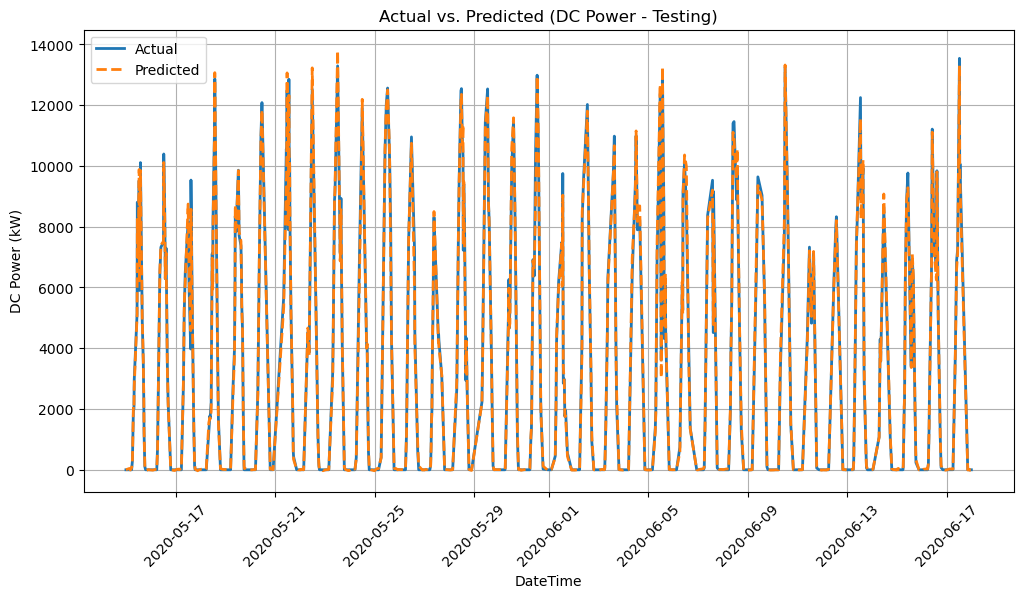

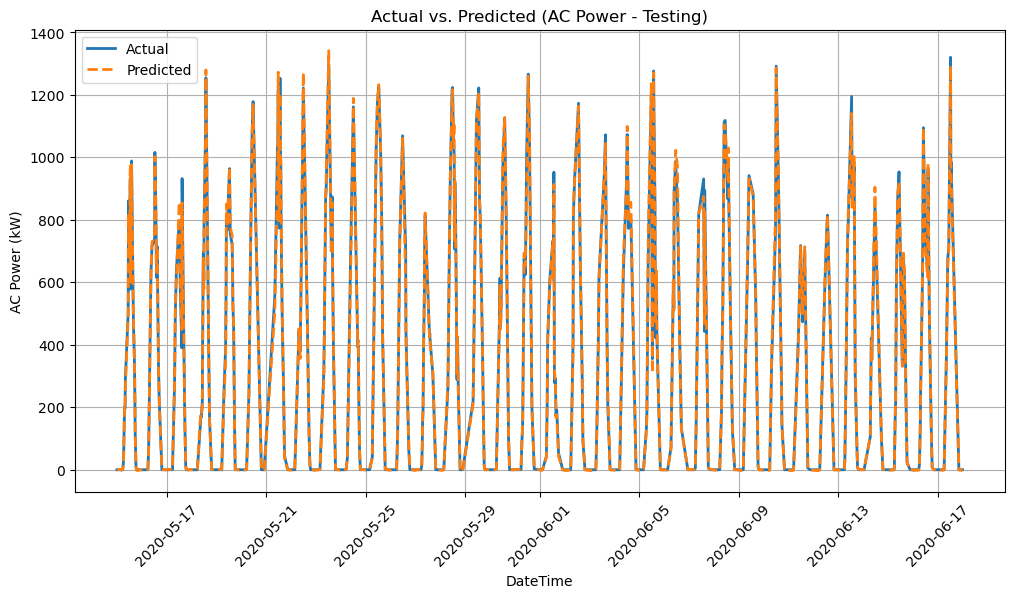

In [15]:
import matplotlib.pyplot as plt

# Function to plot actual vs. predicted values with DateTime as X-axis
def plot_actual_vs_predicted_datetime(df, actual_col, predicted_col, title, xlabel='DateTime', ylabel='Power (kW)'):
    plt.figure(figsize=(12, 6))
    plt.plot(df['DATE_TIME'], df[actual_col], label='Actual', linewidth=2)
    plt.plot(df['DATE_TIME'], df[predicted_col], label='Predicted', linestyle='--', linewidth=2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Prepare DataFrame for DC Power (Testing Data)
test_dc_df = pd.DataFrame({
    'DATE_TIME': merged_data_grouped.loc[y_test_dc.index, 'DATE_TIME'],
    'Actual_DC_Power': y_test_dc,
    'Predicted_DC_Power': test_dc_predictions.flatten()
}).sort_values(by='DATE_TIME')

# Prepare DataFrame for AC Power (Testing Data)
test_ac_df = pd.DataFrame({
    'DATE_TIME': merged_data_grouped.loc[y_test_ac.index, 'DATE_TIME'],
    'Actual_AC_Power': y_test_ac,
    'Predicted_AC_Power': test_ac_predictions.flatten()
}).sort_values(by='DATE_TIME')

# Plot actual vs. predicted for DC Power (Testing Data)
plot_actual_vs_predicted_datetime(test_dc_df, 'Actual_DC_Power', 'Predicted_DC_Power', "Actual vs. Predicted (DC Power - Testing)", xlabel='DateTime', ylabel='DC Power (kW)')

# Plot actual vs. predicted for AC Power (Testing Data)
plot_actual_vs_predicted_datetime(test_ac_df, 'Actual_AC_Power', 'Predicted_AC_Power', "Actual vs. Predicted (AC Power - Testing)", xlabel='DateTime', ylabel='AC Power (kW)')

In [16]:
# Save the trained DC Power Model
best_dc_model.save("DC_model.h5")

# Save the trained AC Power Model
best_ac_model.save("AC_model.h5")

In [17]:
###############################################################################################################################

In [18]:
df1 = pd.read_csv("C:/Users/yujin/Downloads/MONASH/Y3 S3/FIT 3164/fyp/powerconsumption.csv")

In [19]:
print(df1.head())

        Datetime  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
0  1/1/2017 0:00        6.559      73.8      0.083                0.051   
1  1/1/2017 0:10        6.414      74.5      0.083                0.070   
2  1/1/2017 0:20        6.313      74.5      0.080                0.062   
3  1/1/2017 0:30        6.121      75.0      0.083                0.091   
4  1/1/2017 0:40        5.921      75.7      0.081                0.048   

   DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
0         0.119             34055.69620             16128.87538   
1         0.085             29814.68354             19375.07599   
2         0.100             29128.10127             19006.68693   
3         0.096             28228.86076             18361.09422   
4         0.085             27335.69620             17872.34043   

   PowerConsumption_Zone3  
0             20240.96386  
1             20131.08434  
2             19668.43373  
3             18899.27711  
4     

In [20]:
df1['power consumption'] = df1[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']].mean(axis=1)
print(df1.head())

        Datetime  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
0  1/1/2017 0:00        6.559      73.8      0.083                0.051   
1  1/1/2017 0:10        6.414      74.5      0.083                0.070   
2  1/1/2017 0:20        6.313      74.5      0.080                0.062   
3  1/1/2017 0:30        6.121      75.0      0.083                0.091   
4  1/1/2017 0:40        5.921      75.7      0.081                0.048   

   DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
0         0.119             34055.69620             16128.87538   
1         0.085             29814.68354             19375.07599   
2         0.100             29128.10127             19006.68693   
3         0.096             28228.86076             18361.09422   
4         0.085             27335.69620             17872.34043   

   PowerConsumption_Zone3  power consumption  
0             20240.96386       23475.178480  
1             20131.08434       23106.947957  
2    

In [21]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Assuming your DataFrame is named df
df1['Datetime'] = pd.to_datetime(df1['Datetime'])
df1.set_index('Datetime', inplace=True)

# Optional: Create additional time features
df1['hour'] = df1.index.hour
df1['day_of_week'] = df1.index.dayofweek
# Add more as needed

# Select features and target
features1 = df1[['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'hour', 'day_of_week']] # Add or remove features based on your Step 3 decisions
target1 = df1['power consumption']

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features1)
scaled_target = scaler.fit_transform(target1.values.reshape(-1,1))

# Sequence creation (example with a lookback of 3 time steps)
def create_sequences(features, target, sequence_length=3):
    X1, y1 = [], []
    for i in range(len(features) - sequence_length):
        X1.append(features[i:i+sequence_length])
        y1.append(target[i+sequence_length])
    return np.array(X1), np.array(y1).reshape(-1, 1)

X1, y1 = create_sequences(scaled_features, scaled_target, sequence_length=3)

# Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import tensorflow as tf

# Define the GRU model architecture
emodel = Sequential([
    GRU(units=50, return_sequences=True, input_shape=(X_train1.shape[1], X_train1.shape[2])),
    Dropout(0.2),
    GRU(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
emodel.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
emodel.summary()

# Callback to stop training when no improvement is made
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Train the model
history = emodel.fit(X_train1, y_train1, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)


C:\Users\yujin\anaconda3\envs\tf2_cpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 3, 50)          │         8,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,201 (94.54 KB)

 Trainable params: 24,201 (94.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0180 - val_loss: 0.0112
Epoch 2/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0125 - val_loss: 0.0107
Epoch 3/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0116 - val_loss: 0.0104
Epoch 4/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0111 - val_loss: 0.0079
Epoch 5/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0080 - val_loss: 0.0058
Epoch 6/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0067 - val_loss: 0.0055
Epoch 7/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 8/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 9/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 10/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 11/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 12/50
1049/1049 ━━━━━━━━

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on the test data
y_pred1 = emodel.predict(X_test1)

# Inverse transform the predictions and actual values if they were scaled
y_pred_inv1 = scaler.inverse_transform(y_pred1)
y_test_inv1 = scaler.inverse_transform(y_test1)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv1, y_pred_inv1))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate MAE
mae = mean_absolute_error(y_test_inv1, y_pred_inv1)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared (R²)
r2 = r2_score(y_test_inv1, y_pred_inv1)
print("R-squared (R²):", r2)


328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Root Mean Squared Error (RMSE): 1801.8597608306534
Mean Absolute Error (MAE): 1282.8740187102771
R-squared (R²): 0.9007303787923789


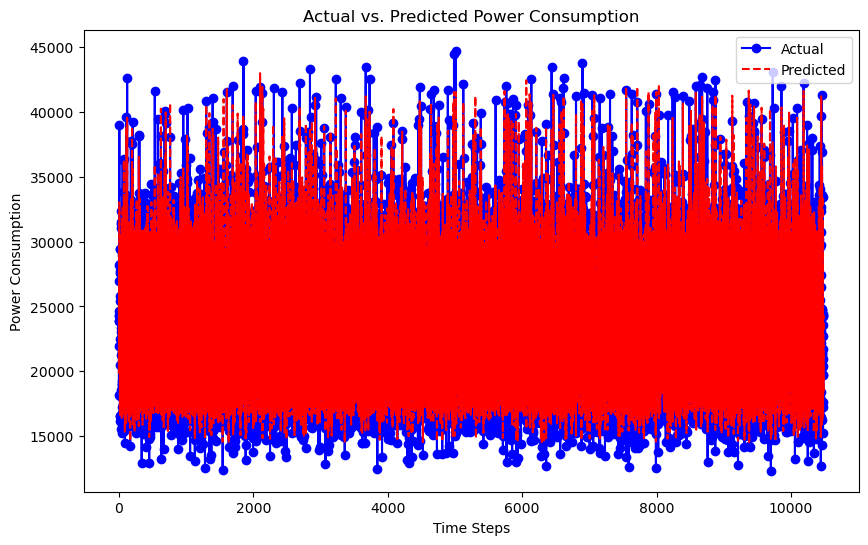

In [24]:
import matplotlib.pyplot as plt

# Assuming y_test_inv and y_pred_inv are your actual and predicted values respectively, already inverse transformed if necessary
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv1, label='Actual', color='blue', marker='o')
plt.plot(y_pred_inv1, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs. Predicted Power Consumption')
plt.xlabel('Time Steps')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()


In [25]:
# Save the trained Power Consumption Model
emodel.save("consumption_model.h5")